In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
from wordcloud import WordCloud 
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.
##      ignore warnings
import warnings
warnings.filterwarnings('ignore')
### Random Forest
from sklearn.ensemble import RandomForestClassifier
### cross validation
from sklearn.model_selection import cross_val_score
#### confusion matrix
from sklearn.metrics import confusion_matrix
### classification report
from sklearn.metrics import classification_report
### accuracy score
from sklearn.metrics import accuracy_score


In [3]:
import easygui

In [4]:
path = easygui.fileopenbox()

In [5]:
path

'/Users/giridharana.r/Desktop/S_Assignments/DATA_245_ML/Project/Tripadvisor_Reviews/CSV/tripadvisor_hotel_reviews.csv'

In [2]:
df = pd.read_csv('/Users/giridharana.r/Desktop/S_Assignments/DATA_245_ML/Project/Tripadvisor_Reviews/CSV/tripadvisor_hotel_reviews.csv')

In [3]:
df.head()

,Review,Rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,",4
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived late night 11 pm inside run bellman busy chating cell phone help bags.prior arrival emailed hotel inform 20th anniversary half really picky wanted make sure good, got nice email saying like deliver bottle champagne chocolate covered strawberries room arrival celebrate, told needed foam pillows, arrival no champagne strawberries no foam pillows great room view alley high rise building good not better housekeeping staff cleaner room property, impressed left morning shopping room got short trips 2 hours, beds comfortable.not good ac-heat control 4 x 4 inch screen bring green shine directly eyes night, light sensitive tape controls.this not 4 start hotel clean business hotel super high rates, better chain hotels seattle,",2
2,"nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv hard use ipod sound dock suite non functioning. decided book mediterranean suite 3 night weekend stay 1st choice rest party filled, comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower.before stay hotel arrange car service price 53 tip reasonable driver waiting arrival.checkin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did n't stay, night got 12/1a checked voucher bottle champagne nice gesture fish waiting room, impression room huge open space felt room big, tv far away bed chore change channel, ipod dock broken disappointing.in morning way asked desk check thermostat said 65f 74 2 degrees warm try cover face night bright blue light kept, got room night no, 1st drop desk, called maintainence came look thermostat told play settings happy digital box wo n't work, asked wakeup 10am morning did n't happen, called later 6pm nap wakeup forgot, 10am wakeup morning yep forgotten.the bathroom facilities great room surprised room sold whirlpool bath tub n't bath amenities, great relax water jets going,",3
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown shopping area, pet friendly room showed no signs animal hair smells, monaco suite sleeping area big striped curtains pulled closed nice touch felt cosy, goldfish n

### EDA

In [4]:
df.shape

(20491, 2)

There are 20491 reviews and 2 columns such as Review and Rating 

In [5]:
df.duplicated().sum()

0

NO duplicates in the dataframe

In [6]:
df["Rating"].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

Five types of Ratings from 1 - 5 with 1 being the lowest and 5 being the highest

In [7]:
px.histogram(df,x = "Rating",color = "Rating",title = "Hotel Ratings", width=600,height=600)

There are more number of positive reviews than negative reviews on seeing the plot

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


Review is in the object format and Rating is in int format

#### Checking the missing values

In [9]:
def missing(df):
    missing_value = df.isnull().sum().sort_values(ascending=False)
    missing_percentage = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    total_missing = pd.concat([missing_value,missing_percentage],axis=1,keys=["Total Missing","Percentage"])
    
    return total_missing
    

In [10]:
missing(df)

,Total Missing,Percentage
Review,0,0.0
Rating,0,0.0


There are no missing values present in the dataset and all the data are labelled

In [11]:
#### Checking for empty strings

df.loc[df["Review"] == ""]

,Review,Rating


There are no empty strings present

#### Word Cloud of all reviews

In [12]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show() 

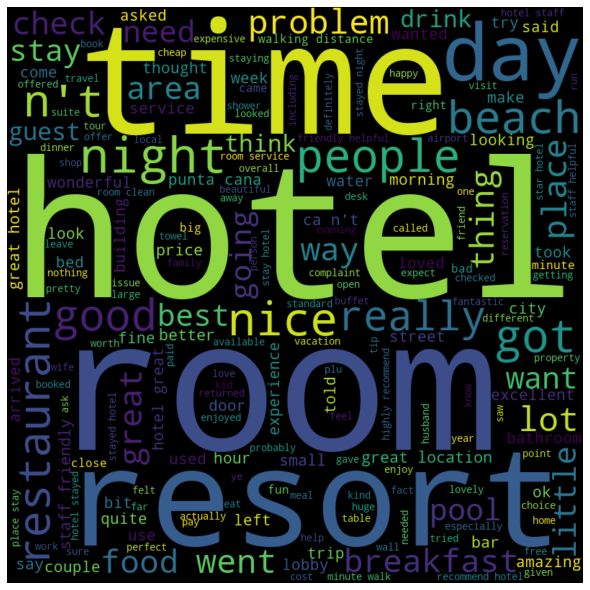

In [13]:
wordCloud_generator(df['Review'])

#### Word count of ratings


In [14]:
df['Review'].value_counts()

nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,                                                                                                                                                                                                                                                                                                                                                                                                                         

In [15]:
df['Word Count'] = df['Review'].apply(lambda x: len(str(x).split(" ")))

In [16]:
df.head()

,Review,Rating,Word Count
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,",4,89
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived late night 11 pm inside run bellman busy chating cell phone help bags.prior arrival emailed hotel inform 20th anniversary half really picky wanted make sure good, got nice email saying like deliver bottle champagne chocolate covered strawberries room arrival celebrate, told needed foam pillows, arrival no champagne strawberries no foam pillows great room view alley high rise building good not better housekeeping staff cleaner room property, impressed left morning shopping room got short trips 2 hours, beds comfortable.not good ac-heat control 4 x 4 inch screen bring green shine directly eyes night, light sensitive tape controls.this not 4 start hotel clean business hotel super high rates, better chain hotels seattle,",2,252
2,"nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv hard use ipod sound dock suite non functioning. decided book mediterranean suite 3 night weekend stay 1st choice rest party filled, comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower.before stay hotel arrange car service price 53 tip reasonable driver waiting arrival.checkin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did n't stay, night got 12/1a checked voucher bottle champagne nice gesture fish waiting room, impression room huge open space felt room big, tv far away bed chore change channel, ipod dock broken disappointing.in morning way asked desk check thermostat said 65f 74 2 degrees warm try cover face night bright blue light kept, got room night no, 1st drop desk, called maintainence came look thermostat told play settings happy digital box wo n't work, asked wakeup 10am morning did n't happen, called later 6pm nap wakeup forgot, 10am wakeup morning yep forgotten.the bathroom facilities great room surprised room sold whirlpool bath tub n't bath amenities, great relax water jets going,",3,219
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown shopping area, pet friendly room showed no signs animal hair smells, monaco suite sleeping area big striped curtains pulled closed nice touch

<AxesSubplot:xlabel='Rating', ylabel='Word Count'>

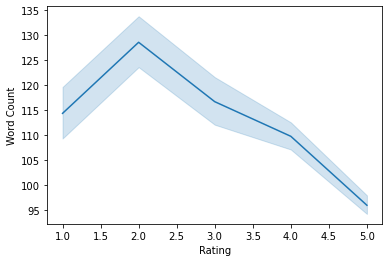

In [17]:
sns.lineplot(x="Rating", y="Word Count", data=df)

### Modelling

In [18]:
df["Rating"].value_counts()


5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

Since there are lots of reviews we can introduce a new column in  which we can take ratings of 4,5 as positive, 3 as neutral and 1,2 as negative. 

In [19]:
df_negative = df.loc[df["Rating"] < 3]
df_negative = df_negative.reset_index(drop=True)

In [20]:
print(len(df_negative))

3214


In [21]:
df_five = df.loc[df["Rating"] == 5]
df_five = df_five.reset_index(drop=True)

In [22]:
print(len(df_five))

9054


In [23]:
df_positive = df_five[:len(df_negative)]


In [24]:
print(len(df_positive))

3214


In [25]:
df_all = pd.concat([df_negative,df_positive],axis=0)


In [26]:
df_all = df_all.reset_index(drop=True)

In [27]:
len(df_all)

6428

In [28]:
df_all.head()

,Review,Rating,Word Count
0,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived late night 11 pm inside run bellman busy chating cell phone help bags.prior arrival emailed hotel inform 20th anniversary half really picky wanted make sure good, got nice email saying like deliver bottle champagne chocolate covered strawberries room arrival celebrate, told needed foam pillows, arrival no champagne strawberries no foam pillows great room view alley high rise building good not better housekeeping staff cleaner room property, impressed left morning shopping room got short trips 2 hours, beds comfortable.not good ac-heat control 4 x 4 inch screen bring green shine directly eyes night, light sensitive tape controls.this not 4 start hotel clean business hotel super high rates, better chain hotels seattle,",2,252
1,"poor value stayed monaco seattle july, nice hotel priced 100- 150 night not, hotel takes beating quotient, experience simply average, nothing exceptional paying 300+ n't ca n't terribly disappointed, wife stayed nicest suites 200/night felt like overpaying, best advice shop, quality-wise league average marriott nice best western,",2,49
2,"horrible customer service hotel stay february 3rd 4th 2007my friend picked hotel monaco appealing website online package included champagne late checkout 3 free valet gift spa weekend, friend checked room hours earlier came later, pulled valet young man just stood, asked valet open said, pull bags didn__Ç_é_ offer help, got garment bag suitcase came car key room number says not valet, car park car street pull, left key working asked valet park car gets, went room fine bottle champagne oil lotion gift spa, dressed went came got bed noticed blood drops pillows sheets pillows, disgusted just unbelievable, called desk sent somebody 20 minutes later, swapped sheets left apologizing, sunday morning called desk speak management sheets aggravated rude, apparently no manager kind supervisor weekend wait monday morning, young man spoke said cover food adding person changed sheets said fresh blood rude tone, checkout 3pm package booked, 12 1:30 staff maids tried walk room opening door apologizing closing, people called saying check 12 remind package, finally packed things went downstairs check, quickly signed paper took, way took closer look room, unfortunately covered food offered charged valet, called desk ask charges lady answered snapped saying aware problem experienced monday like told earlier, life treated like hotel, not sure hotel constantly problems lucky ones stay recommend anybody know,",1,216
3,"disappointed say anticipating stay hotel monaco based reviews seen tripadvisor, definitely disppointment, decor room hotel envisioned nice, housekeeping staff impressive extremely polite cheery helpful, desk bellmen standard customer service, lots little things easily overlooked broken make mirror sagging post bathroom jiggly entrance handle room did n't feel secure handle nearly falling door, husband early morning flight mid-week asked cab called, suggested cab ride cost double private car flat-rate n't ca

In [29]:
df_all["Rating"].value_counts()

5    3214
2    1793
1    1421
Name: Rating, dtype: int64

#### Creating a sentiments column

In [30]:
df_all["Sentiment"]  = np.where(df_all["Rating"] == 5, "Positive", "Negative")

In [31]:
df_all.tail()

,Review,Rating,Word Count,Sentiment
6423,"really cozy place enjoyed stay, just came short stay library hotel, picked hotel remembered spent lovely evening roof terrace year ago, reading reviews curious rest hotel.everybody desk helpful friendly did swift check-in, lobby understated minimalist book shelves look booked junior suit special discount price 499 new york substantial money expected lot.i not disappointed, room looked exactly like picture website, lot room wasted room/hallway spacious airy lot windows, nice wooden blinds gave room warm feeling did room colours beige dark wood, small sofa corner armchairs large flat screen tv, bathroom spacious nicely decorated amenities needs.having lived new york knew not going quietest streets mid-town, definitely noisy windows sound-proof.i did not reading room spent time upstairs winter garden course roof terrace, nice rooftop terrace comfortable furniture, benches little stools quite uncomfortable impossible spent leisure afternoon sun major backache, free hotspot available terrace able emails sitting sun not hotels ny offer travellers said great place worth money return,",5,157,Positive
6424,"perfect hotel hotel does not really need glowing review nice add, stayed great attention, room lovely public areas beautiful especially bar 14th floor staff not nicer, petite room reviews n't normal sized double room, suppose does small american room normally queen beds just normal double room, not occurred think room size not described petite room, stayed husband nights fine,",5,61,Positive
6425,"perfect hotel small hotel comfortable perfect location helpful staff good, visit new york come love room no doubt,",5,20,Positive
6426,"ordinary location extraordinary hotel know lovely boutique hotel got positive reviews, stayed based tripadvisor reviews pleased, night stay nov 16 room, small perfect person small suitcase, design dÄcor space furnishings simple elegant line, room didn__Ç_é_ feel cramped small person, room windows good lighting__Ç_ecessary want try interesting books shelf, room bath spotlessly clean, room 11th floor little street noise heard, there__Ç_é_ no room service complimentary food beverages available day long second floor continental breakfast morning coffee tea cookies afternoon wine cheese early evening, hotel staff highly professional friendly helpful address just ask, 41st madison address isn__Ç_é_ trendy nyc areas hotel definitely worth stay, i__Ç_éêl going january reserved room,",5,109,Positive
6427,"classy indulgence awesome experience, staff n't chocolates left day complimentary bottles water, travelling south america just little bit pampering needed perfectly located close, nice end town midtown believe used lingo, food really great, really exceptional cheeses husband said wine pretty great, perfect snacks lunch dinner, just loved place, bought mug remember time, thank staff making ny trip remember, just aware prices upper end ny hotels expensive not classy,",5,70,Positive


#### Randomizing the data


In [32]:
df_all = df_all.sample(frac=1)
df_all = df_all.reset_index(drop=True)

In [33]:
df_all.tail()

,Review,Rating,Word Count,Sentiment
6423,"overall not recommend hotel young american boyfriend stayed pcp 1/26-1/30, got hotel asked upgrade vip, person dest hardly spoke english, beg vip items cigars rum robes free massage dinner internet motorized watersports did not recieve vouchers 3rd day attitude add, got room regular 2- double bed room not vip ased changed told overbooked change day, changed 1pm day vip room unkept appeared dirtier, staying ground floor sliding door broken, immediately checked doors read review 14 people robbed sliding door broken, called room changed said send fix door, went original room 3pm time wasted day just situated, waiters/ waitressess/ bartenders/ maids nice desk unhelpful especially problem, food terrible sick 3 days, charge 15 dollars immodium suggest bringing, need money want change american dollars mac machines peso fron desk wont tell town airport change not true, casino change, jipped motorized water sports said windy, going away just relax place nice, say beautiful beaches pool clean, n't bother upgrading vip didnt use vouchers, prepared pay, people expect tipped bring plenty, overall place good families, resort turns total ghosttown night, nothing, open alot read reviews did n't want spoil vacation right no entertainment food terrible desk does not help problems complain ignore attitude, spread bring walking shoes let know fiasco vip like said desk b/f lost vip bracelet went new woman counter told cost replace new bracelet plus pay vip, did not room man dest told vip free charge problems rooms not receiving vouchers, argued 20 minutes saying no gets free asked downgrade said charge 60 resturaunt ate bar went drink charge, threatened appauled, threatened resort no matter problem, completely unnacceptable behavior want let know type service expect, questions/ comments welcome e-mail, resort suggest not bother wasting time, booked trip just try make, hopefully wont experience,",1,294,Negative
6424,"charme elegance beautiful period hotel kind friendly service midst heart paris, near feel paris best,",5,17,Positive
6425,"need street wise, stayed 2 weeks 35 night dbl rm, fantastically cheap agent london bt pay, clean room bt desperately old decor, cigarette burns carpet clean bedding, rm cleaned/bed changed 3 days, web page totally inaccurate, no restaurant famous veggie restaurant closed years ago no tea/coffee making facilities staff pleasant bt uninterested no additional information tourist advice given leaflets slightly grubby foyer, area incredible view beautiful city hall rough neighborhood title review, heard arguments hotel manager long term residents glass foyer door kicked police visited evict tenant.i suggest young travel wise backpackers stay nights only.traditional tourists wo n't like, families children absolutely not,",2,105,Negative
6426,"location 10 hotel 2 know really got pretty bad experience hotel feel need log trip advisor rate place 48 hours getting home, second comments overall feel place n't know hotel featuring website parts saw including creepy dingy room labyrinthine gerbil cage hallways looked like n't cleaned painted 70, room dated awful cheap paneling, twin beds like sleeping slab surgical theatre, required creaky anxiety inducing elevator rides meters walk just floor room, staff really unfriendly case florence places, sequestered airless dark meeting space breakfast breakfast tables filled, 350 night hotel positive location,",1,93,Negative
6427,"art landscape spoiling stayed week mid-november 2004 brand new resort variety comments available just want depict personal goods bads.reception confirm impression arrogance uselessness, needed 1.5 hours got room, disappointing following did not pre-pay stay presented credit card charge, signboard desk shows exchange rate 24.00 dop dollar official rate 30.00 dop, calculation 36.00 dop multiplied dollar-quoted room rate, just explain similar price increase 20, denied payment left open unsuccessfully tried responsible mana

### Data preprocessing

In [34]:
df_all.shape

(6428, 4)

In [35]:
df_new = df_all[['Review','Sentiment']]

In [36]:
df_new.head(5)

,Review,Sentiment
0,"average punta cana resort great beach spent week resort june wife daughter 3rd time punta cana riu bambu melia caribe liked better, positives grant flamenco good size not big not small landscape perfect kept like shopping souvenirs shopping plaza walking distance hotel aware sellers extremely annoying hard store buy stuff, night shows good got little tired performers week long, nice 1-hour snorkeling place 20, beach gorgeous overweights negatives, negatives poor service restaurants desk days room, food o-key not hungry not expect gourmet delights daily menu, a-la-corte restaurants worse expected clean nice interior food presentation not taste, outdated room furnishing, money cautious really good deal resort not regret visit,",Negative
1,"say dump worst nastiest place stayed didnt clean sheets place looked cleaned roaches size rats electric didnt work lot places phone didnt work furniture busted going ive said place going make guess house decent crew new furniture god sake just needs redone way,",Negative
2,"centre recommended avenida palace travel agent waterford couldn'tve picked better hotel night stay barcelona, perfectly located passeig gracia train station 20mins direct barcelona airport warmly greeted office staff especially mar fernando.we happy room looked street, whilst did n't dine hotel happily helped reserve table shunka location near shops restaurants definately recommend avenida weekend weeks stay,",Positive
3,"service wonderful husband stayed hotel long weekend, greeted warmly staff pleased not able check room noon requested view chuch center.each day stopped spoke staff, concierge friendly interested doing, stay waldorf andimust say felt service better, rooms luxurious standard husband liked remote control bedside, usually book suites waldorf enjoy traveling son.i write review manager graciously extended stay lovely room moments notice told hotel desk maid let room locked nice man entrance not able attention cab allowed wonderful ride hotels car theater feel special welcome time returned left hotel..my husband says particiular know not easy really did, thanks making anniversary perfect hello virgin islands,",Positive
4,"stay away, conjure great expectations reality grim, masquerade 4* hotel belief, room 11th, floor jaded say old carpetting soiled wall covering electrical socket loose wall wash basin drained slowly say did snail pace offensive snails toilet bowl flushed filled rim drained equally slowly obviously blockages antiquated airconditioning complete control came away hand not adjusted, rooms obviously dire need refurbishment redecoration.the overpriced buffet breakfast equivalent head not worth glance.on positive good position swimming pools.however hard pressed poorer stopover singapore,",Negative


In [37]:
df_new.shape

(6428, 2)

In [38]:
### stripping html tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

### expanding the contractions
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)
#remove the numericals present in the text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text
def clean_text(text):
    text = replace_contractions(text)
    text = strip_html_tags(text)
    text = remove_numbers(text)
    return text


In [39]:
#### applying in the dataframe
df_new['Review'] = df_new['Review'].apply(lambda x: clean_text(x))

In [40]:
df_new.head(5)

,Review,Sentiment
0,"average punta cana resort great beach spent week resort june wife daughter rd time punta cana riu bambu melia caribe liked better, positives grant flamenco good size not big not small landscape perfect kept like shopping souvenirs shopping plaza walking distance hotel aware sellers extremely annoying hard store buy stuff, night shows good got little tired performers week long, nice -hour snorkeling place , beach gorgeous overweights negatives, negatives poor service restaurants desk days room, food o-key not hungry not expect gourmet delights daily menu, a-la-corte restaurants worse expected clean nice interior food presentation not taste, outdated room furnishing, money cautious really good deal resort not regret visit,",Negative
1,"say dump worst nastiest place stayed did not clean sheets place looked cleaned roaches size rats electric did not work lot places phone did not work furniture busted going i have said place going make guess house decent crew new furniture god sake just needs redone way,",Negative
2,"centre recommended avenida palace travel agent waterford could not have picked better hotel night stay barcelona, perfectly located passeig gracia train station mins direct barcelona airport warmly greeted office staff especially mar fernando.we happy room looked street, whilst did n't dine hotel happily helped reserve table shunka location near shops restaurants definately recommend avenida weekend weeks stay,",Positive
3,"service wonderful husband stayed hotel long weekend, greeted warmly staff pleased not able check room noon requested view chuch center.each day stopped spoke staff, concierge friendly interested doing, stay waldorf andimust say felt service better, rooms luxurious standard husband liked remote control bedside, usually book suites waldorf enjoy traveling son.i write review manager graciously extended stay lovely room moments notice told hotel desk maid let room locked nice man entrance not able attention cab allowed wonderful ride hotels car theater feel special welcome time returned left hotel..my husband says particiular know not easy really did, thanks making anniversary perfect hello virgin islands,",Positive
4,"stay away, conjure great expectations reality grim, masquerade * hotel belief, room th, floor jaded say old carpetting soiled wall covering electrical socket loose wall wash basin drained slowly say did snail pace offensive snails toilet bowl flushed filled rim drained equally slowly obviously blockages antiquated airconditioning complete control came away hand not adjusted, rooms obviously dire need refurbishment redecoration.the overpriced buffet breakfast equivalent head not worth glance.on positive good position swimming pools.however hard pressed poorer stopover singapore,",Negative


#### Tokenizing the reviews


In [41]:
df_new['Review'] = df_new.apply(lambda x: nltk.word_tokenize(x['Review']), axis=1)

In [42]:
df_new.head(5)

,Review,Sentiment
0,"[average, punta, cana, resort, great, beach, spent, week, resort, june, wife, daughter, rd, time, punta, cana, riu, bambu, melia, caribe, liked, better, ,, positives, grant, flamenco, good, size, not, big, not, small, landscape, perfect, kept, like, shopping, souvenirs, shopping, plaza, walking, distance, hotel, aware, sellers, extremely, annoying, hard, store, buy, stuff, ,, night, shows, good, got, little, tired, performers, week, long, ,, nice, -hour, snorkeling, place, ,, beach, gorgeous, overweights, negatives, ,, negatives, poor, service, restaurants, desk, days, room, ,, food, o-key, not, hungry, not, expect, gourmet, delights, daily, menu, ,, a-la-corte, restaurants, worse, expected, clean, nice, interior, food, presentation, ...]",Negative
1,"[say, dump, worst, nastiest, place, stayed, did, not, clean, sheets, place, looked, cleaned, roaches, size, rats, electric, did, not, work, lot, places, phone, did, not, work, furniture, busted, going, i, have, said, place, going, make, guess, house, decent, crew, new, furniture, god, sake, just, needs, redone, way, ,]",Negative
2,"[centre, recommended, avenida, palace, travel, agent, waterford, could, not, have, picked, better, hotel, night, stay, barcelona, ,, perfectly, located, passeig, gracia, train, station, mins, direct, barcelona, airport, warmly, greeted, office, staff, especially, mar, fernando.we, happy, room, looked, street, ,, whilst, did, n't, dine, hotel, happily, helped, reserve, table, shunka, location, near, shops, restaurants, definately, recommend, avenida, weekend, weeks, stay, ,]",Positive
3,"[service, wonderful, husband, stayed, hotel, long, weekend, ,, greeted, warmly, staff, pleased, not, able, check, room, noon, requested, view, chuch, center.each, day, stopped, spoke, staff, ,, concierge, friendly, interested, doing, ,, stay, waldorf, andimust, say, felt, service, better, ,, rooms, luxurious, standard, husband, liked, remote, control, bedside, ,, usually, book, suites, waldorf, enjoy, traveling, son.i, write, review, manager, graciously, extended, stay, lovely, room, moments, notice, told, hotel, desk, maid, let, room, locked, nice, man, entrance, not, able, attention, cab, allowed, wonderful, ride, hotels, car, theater, feel, special, welcome, time, returned, left, hotel, .., my, husband, says, particiular, know, not, easy, ...]",Positive
4,"[stay, away, ,, conjure, great, expectations, reality, grim, ,, masquerade, *, hotel, belief, ,, room, th, ,, floor, jaded, say, old, carpetting, soiled, wall, covering, electrical, socket, loose, wall, wash, basin, drained, slowly, say, did, snail, pace, offensive, snails, toilet, bowl, flushed, filled, rim, drained, equally, slowly, obviously, blockages, antiquated, airconditioning, complete, control, came, away, hand, not, adjusted, ,, rooms, obviously, dire, need, refurbishment, redecoration.the, overpriced, buffet, breakfast, equivalent, head, not, worth, glance.on, positive, good, position, swimming, pools.however, hard, pressed, poorer, stopover, singapore, ,]",Negative


#### Removing stop words and lemmatization

In [124]:
stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

### removing the non ascii characters
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

### converting all the words to lower case
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

### removing the punctuations
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

#### removing the stopwords
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

# lemmatize the words
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def stop_lemma(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join (words)





In [44]:
df_new['Review'] = df_new.apply(lambda x: stop_lemma(x['Review']),axis=1)

In [45]:
df_new.head(5)

,Review,Sentiment
0,average punta cana resort great beach spend week resort june wife daughter rd time punta cana riu bambu melia caribe like better positives grant flamenco good size big small landscape perfect keep like shop souvenirs shop plaza walk distance hotel aware sellers extremely annoy hard store buy stuff night show good get little tire performers week long nice hour snorkel place beach gorgeous overweights negative negative poor service restaurants desk days room food okey hungry expect gourmet delight daily menu alacorte restaurants worse expect clean nice interior food presentation taste outdated room furnish money cautious really good deal resort regret visit,Negative
1,say dump worst nastiest place stay clean sheet place look clean roach size rat electric work lot place phone work furniture bust go say place go make guess house decent crew new furniture god sake need redo way,Negative
2,centre recommend avenida palace travel agent waterford could pick better hotel night stay barcelona perfectly locate passeig gracia train station mins direct barcelona airport warmly greet office staff especially mar fernandowe happy room look street whilst nt dine hotel happily help reserve table shunka location near shop restaurants definately recommend avenida weekend weeks stay,Positive
3,service wonderful husband stay hotel long weekend greet warmly staff please able check room noon request view chuch centereach day stop speak staff concierge friendly interest stay waldorf andimust say felt service better room luxurious standard husband like remote control bedside usually book suit waldorf enjoy travel soni write review manager graciously extend stay lovely room moments notice tell hotel desk maid let room lock nice man entrance able attention cab allow wonderful ride hotels car theater feel special welcome time return leave hotel husband say particiular know easy really thank make anniversary perfect hello virgin islands,Positive
4,stay away conjure great expectations reality grim masquerade hotel belief room th floor jade say old carpetting soil wall cover electrical socket loose wall wash basin drain slowly say snail pace offensive snail toilet bowl flush fill rim drain equally slowly obviously blockages antiquate airconditioning complete control come away hand adjust room obviously dire need refurbishment redecorationthe overprice buffet breakfast equivalent head worth glanceon positive good position swim poolshowever hard press poorer stopover singapore,Negative


The above data has been cleaned and preprocessed and we can now start building our model.

#### Preparing model using CountVectorizer and Tfidf

In [46]:
replaceStruct = {
                "Sentiment": {"Positive": 1, "Negative": 0}
                }

In [47]:
df_new = df_new.replace(replaceStruct)

In [48]:
df_new.head(5)

,Review,Sentiment
0,average punta cana resort great beach spend week resort june wife daughter rd time punta cana riu bambu melia caribe like better positives grant flamenco good size big small landscape perfect keep like shop souvenirs shop plaza walk distance hotel aware sellers extremely annoy hard store buy stuff night show good get little tire performers week long nice hour snorkel place beach gorgeous overweights negative negative poor service restaurants desk days room food okey hungry expect gourmet delight daily menu alacorte restaurants worse expect clean nice interior food presentation taste outdated room furnish money cautious really good deal resort regret visit,0
1,say dump worst nastiest place stay clean sheet place look clean roach size rat electric work lot place phone work furniture bust go say place go make guess house decent crew new furniture god sake need redo way,0
2,centre recommend avenida palace travel agent waterford could pick better hotel night stay barcelona perfectly locate passeig gracia train station mins direct barcelona airport warmly greet office staff especially mar fernandowe happy room look street whilst nt dine hotel happily help reserve table shunka location near shop restaurants definately recommend avenida weekend weeks stay,1
3,service wonderful husband stay hotel long weekend greet warmly staff please able check room noon request view chuch centereach day stop speak staff concierge friendly interest stay waldorf andimust say felt service better room luxurious standard husband like remote control bedside usually book suit waldorf enjoy travel soni write review manager graciously extend stay lovely room moments notice tell hotel desk maid let room lock nice man entrance able attention cab allow wonderful ride hotels car theater feel special welcome time return leave hotel husband say particiular know easy really thank make anniversary perfect hello virgin islands,1
4,stay away conjure great expectations reality grim masquerade hotel belief room th floor jade say old carpetting soil wall cover electrical socket loose wall wash basin drain slowly say snail pace offensive snail toilet bowl flush fill rim drain equally slowly obviously blockages antiquate airconditioning complete control come away hand adjust room obviously dire need refurbishment redecorationthe overprice buffet breakfast equivalent head worth glanceon positive good position swim poolshowever hard press poorer stopover singapore,0


In [49]:
df_new["Sentiment"].value_counts()

0    3214
1    3214
Name: Sentiment, dtype: int64

<AxesSubplot:>

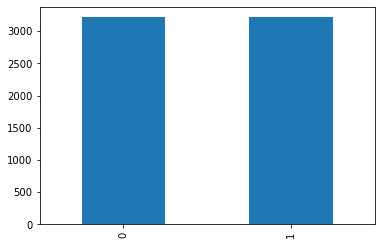

In [50]:
df_new["Sentiment"].value_counts().plot(kind='bar')

There is a class balance present in the data.

### CountVectorizer

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

In [52]:
count_vect = CountVectorizer(max_features=500)
data_features = count_vect.fit_transform(df_new['Review'])
data_features = data_features.toarray()


In [53]:
data_features.shape


(6428, 500)

In [54]:
print(count_vect.get_feature_names())

['able', 'absolutely', 'ac', 'access', 'activities', 'actually', 'add', 'afternoon', 'air', 'airport', 'allow', 'amaze', 'american', 'appear', 'area', 'areas', 'arrival', 'arrive', 'ask', 'available', 'average', 'avoid', 'away', 'awesome', 'bad', 'bag', 'balcony', 'bar', 'base', 'bath', 'bathroom', 'bathrooms', 'bavaro', 'beach', 'beautiful', 'bed', 'believe', 'best', 'better', 'big', 'bite', 'block', 'boat', 'book', 'bother', 'bottle', 'break', 'breakfast', 'bring', 'buffet', 'bug', 'build', 'bus', 'business', 'busy', 'buy', 'ca', 'call', 'cana', 'car', 'card', 'care', 'carpet', 'casino', 'center', 'central', 'certainly', 'chair', 'change', 'charge', 'charm', 'cheap', 'check', 'checkin', 'cheese', 'children', 'choice', 'choose', 'city', 'clean', 'close', 'club', 'coffee', 'cold', 'come', 'comfortable', 'comment', 'complain', 'completely', 'complimentary', 'concierge', 'condition', 'consider', 'convenient', 'cool', 'corner', 'cost', 'country', 'couple', 'course', 'credit', 'crowd', 'cu

In [55]:
print(data_features)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


In [56]:
X = data_features
y = df_new['Sentiment']

In [57]:
print(X.shape)
print(y.shape)


(6428, 500)
(6428,)


In [58]:
### splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,shuffle=False)

In [59]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(5142, 500)
(1286, 500)
(5142,)
(1286,)


In [60]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = np.arange(100,400,100).tolist()
base_ln

[100, 200, 300]

In [61]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    print(type(clf))
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    print(scores)
    cv_scores.append(scores.mean())
cv_scores

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
[0.90864917 0.91350826 0.90661479 0.9270428  0.89785992]
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
[0.90864917 0.90962099 0.91050584 0.92023346 0.91050584]
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
[0.91059281 0.9154519  0.90953307 0.93093385 0.91342412]


[0.9107349888259918, 0.9119030602791423, 0.9159871508358763]

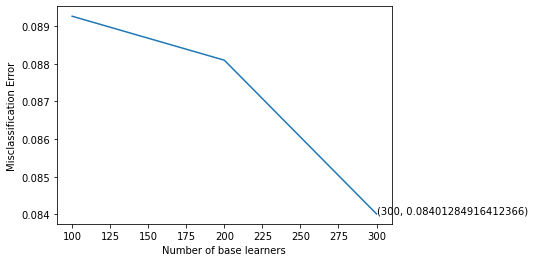

In [62]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [63]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
count_vectorizer_predicted = clf.predict(X_test)
print(classification_report(y_test ,count_vectorizer_predicted , target_names = ['1' , '0']))
print("Accuracy of the model is : ",accuracy_score(y_test,count_vectorizer_predicted))

              precision    recall  f1-score   support

           1       0.91      0.91      0.91       623
           0       0.92      0.92      0.92       663

    accuracy                           0.91      1286
   macro avg       0.91      0.91      0.91      1286
weighted avg       0.91      0.91      0.91      1286

Accuracy of the model is :  0.9136858475894246


great,wonderful,love,excellent,tell,room,perfect,worst,dirty,friendly,comfortable,fantastic,rude,pay,helpful,bad,poor,ok,staff,terrible,best,highly,location,charge,smell,horrible,fabulous,nt,wall,amaze,enjoy,hotel,quiet,recommend,toilet,spacious,star,stay,desk,call,
 
 


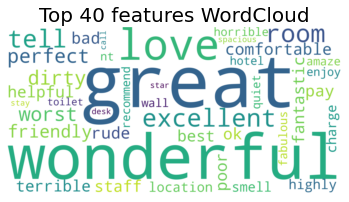

In [64]:
all_features = count_vect.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=','
    
print(top_features)  

print(" ") 
print(" ")     

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

#### TfIdf vectorizer


In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [66]:
tfidf_vect = TfidfVectorizer(max_features=1000) ###change the maximun number of features
data_features = tfidf_vect.fit_transform(df_new['Review'])
data_features = data_features.toarray()
data_features.shape

(6428, 1000)

In [67]:
print(tfidf_vect.get_feature_names())

['able', 'absolutely', 'ac', 'access', 'accommodate', 'activities', 'actually', 'add', 'additional', 'adequate', 'adults', 'advance', 'advantage', 'advertise', 'advice', 'advise', 'advisor', 'afternoon', 'age', 'agent', 'ago', 'agree', 'air', 'airport', 'allinclusive', 'allow', 'alot', 'amaze', 'amenities', 'american', 'americans', 'amsterdam', 'anniversary', 'annoy', 'answer', 'apparently', 'appear', 'apple', 'appoint', 'appreciate', 'april', 'area', 'areas', 'arrange', 'arrival', 'arrive', 'ask', 'atmosphere', 'attempt', 'attention', 'attentive', 'attitude', 'attractions', 'august', 'available', 'average', 'avoid', 'aware', 'away', 'awesome', 'awful', 'bad', 'bag', 'balcony', 'bambu', 'bar', 'barcelona', 'barely', 'bartenders', 'base', 'basic', 'basically', 'bath', 'bathroom', 'bathrooms', 'bavaro', 'beach', 'beat', 'beautiful', 'bed', 'bedroom', 'beer', 'begin', 'believe', 'bell', 'best', 'better', 'beware', 'big', 'biggest', 'bill', 'birthday', 'bite', 'black', 'block', 'blow', 'bl

In [68]:
print(data_features)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.1266066  0.         ... 0.         0.         0.15774523]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [69]:
X = data_features
y = df_new['Sentiment']


In [70]:
### splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,shuffle=False)

In [71]:
print("X_train size:",X_train.shape)
print("X_test size:",X_test.shape)
print("y_train size:",y_train.shape)
print("y_test size:",y_test.shape)


X_train size: (5142, 1000)
X_test size: (1286, 1000)
y_train size: (5142,)
y_test size: (1286,)


In [72]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = np.arange(100,400,100).tolist()
base_ln

[100, 200, 300]

In [73]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    print(scores)
    cv_scores.append(scores.mean())
cv_scores

[0.9047619  0.91836735 0.91828794 0.93871595 0.92607004]
[0.91253644 0.93002915 0.92023346 0.9348249  0.92898833]
[0.91253644 0.92905734 0.92023346 0.93190661 0.93287938]


[0.921240636332354, 0.9253224580549284, 0.9253226471244418]

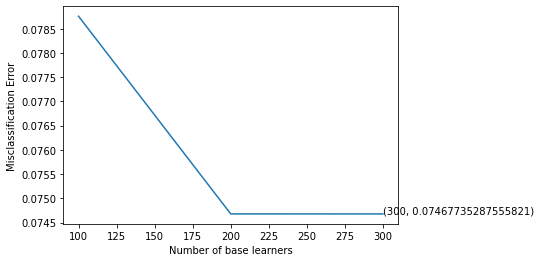

In [74]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

## Random Forest without hyperparameter tuning


In [75]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
tf_idf_predicted = clf.predict(X_test)
print(classification_report(y_test , tf_idf_predicted , target_names = ['0' , '1']))
print("Accuracy of the model is : ",accuracy_score(y_test,tf_idf_predicted))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       623
           1       0.92      0.93      0.92       663

    accuracy                           0.92      1286
   macro avg       0.92      0.92      0.92      1286
weighted avg       0.92      0.92      0.92      1286

Accuracy of the model is :  0.9206842923794712


[[569  54]
 [ 48 615]]


<AxesSubplot:>

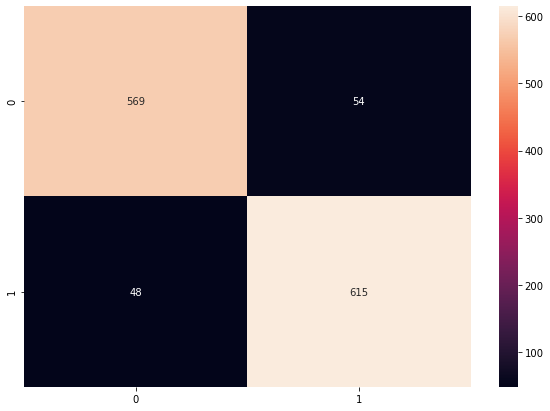

In [76]:

conf_mat = confusion_matrix(y_test, tf_idf_predicted)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['0', '1']],
                  columns = [i for i in ['0', '1']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

great, wonderful, love, excellent, friendly, tell, room, perfect, worst, helpful, fantastic, dirty, comfortable, pay, staff, best, poor, rude, bad, ok, location, terrible, enjoy, highly, charge, horrible, smell, amaze, recommend, quiet, fabulous, call, spacious, finally, definitely, wall, toilet, nt, stay, walk, 
 
 


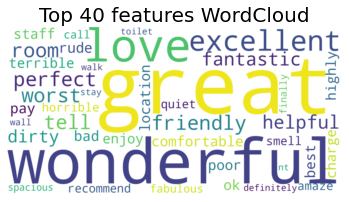

In [77]:
all_features = tfidf_vect.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=', '
    
print(top_features)  

print(" ") 
print(" ") 

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

In [78]:
#convert the test samples into a dataframe where the columns are
#the y_test(ground truth labels),tf-idf model predicted labels(tf_idf_predicted),Count Vectorizer model predicted labels(count_vectorizer_predicted)
df = pd.DataFrame(y_test.tolist(),columns =['y_test'])
df['count_vectorizer_predicted'] = count_vectorizer_predicted
df['tf_idf_predicted'] = tf_idf_predicted
df.head()

,y_test,count_vectorizer_predicted,tf_idf_predicted
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


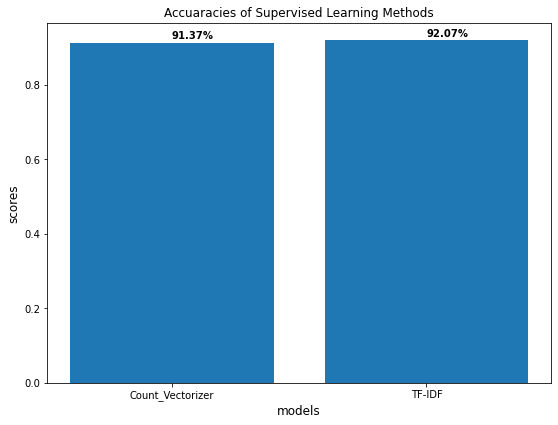

In [79]:
#create bar plot to compare the accuaracies of Count Vectorizer and TF-IDF
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])
subjects = ['Count_Vectorizer', 'TF-IDF']

# calculation accuracies of Count Vectorizer and TF-IDF using accuracy_score metrics
scores = [accuracy_score(y_test,count_vectorizer_predicted),accuracy_score(y_test,tf_idf_predicted)]
ax.bar(subjects,scores)
ax.set_ylabel('scores',fontsize= 12)    # y axis label
ax.set_xlabel('models',fontsize= 12)    # x axis label
ax.set_title('Accuaracies of Supervised Learning Methods')  # tittle
for i, v in enumerate(scores):
    ax.text( i ,v+0.01, '{:.2f}%'.format(100*v), color='black', fontweight='bold')     
    plt.savefig('barplot_1.png',dpi=100, format='png', bbox_inches='tight')
plt.show()

TFIDF performs slightly better than CountVectorizer

SO we will use TFIDF vectorizer for our model

## Modeling

In [80]:
tfidf_vect = TfidfVectorizer(max_features=1000) ###change the maximun number of features
data_features1 = tfidf_vect.fit_transform(df_new['Review'])
data_features1 = data_features1.toarray()
data_features1.shape

(6428, 1000)

In [81]:
X1 = data_features1
y1 = df_new['Sentiment']

In [82]:
### splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=0,shuffle=False)

In [83]:
print("X_train size:",X_train.shape)
print("X_test size:",X_test.shape)
print("y_train size:",y_train.shape)
print("y_test size:",y_test.shape)


X_train size: (5142, 1000)
X_test size: (1286, 1000)
y_train size: (5142,)
y_test size: (1286,)


In [84]:
# #### GridSearchCV for RandomForestClassifier
# from sklearn.model_selection import GridSearchCV


In [85]:
# clf = RandomForestClassifier()
# param_grid = { 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
#                 'max_features': ['auto', 'sqrt', 'log2'],
#                 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
#                 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
#                 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#                 'bootstrap': [True, False],
#                 'criterion': ['gini', 'entropy']}
# grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(X_train, y_train)



In [86]:
# df_results = pd.DataFrame(grid_search.cv_results_)

### Naive Bayes


In [87]:
#### naive bayes classifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score


In [88]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

### Gaussian Naive Bayes

In [89]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test,y_pred1))
print("Confusion Matrix: ",'\n' ,confusion_matrix(y_test,y_pred1))
print("Precision score: ",precision_score(y_test,y_pred1))
print("Classification Report: ",'\n' ,classification_report(y_test,y_pred1))

Accuracy Score:  0.911353032659409
Confusion Matrix:  
 [[567  56]
 [ 58 605]]
Precision score:  0.9152798789712556
Classification Report:  
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       623
           1       0.92      0.91      0.91       663

    accuracy                           0.91      1286
   macro avg       0.91      0.91      0.91      1286
weighted avg       0.91      0.91      0.91      1286



<AxesSubplot:>

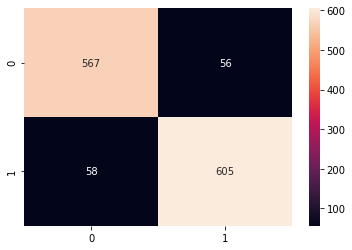

In [90]:
sns.heatmap(confusion_matrix(y_test,y_pred1),annot=True,fmt='g')

### Multinomial Naive Bayes

In [91]:
mnb.fit(X_train,y_train)
y_pred1 = mnb.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test,y_pred1))
print("Confusion Matrix: ",'\n' ,confusion_matrix(y_test,y_pred1))
print("Precision score: ",precision_score(y_test,y_pred1))
print("Classification Report: ",'\n' ,classification_report(y_test,y_pred1))

Accuracy Score:  0.9432348367029549
Confusion Matrix:  
 [[579  44]
 [ 29 634]]
Precision score:  0.9351032448377581
Classification Report:  
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       623
           1       0.94      0.96      0.95       663

    accuracy                           0.94      1286
   macro avg       0.94      0.94      0.94      1286
weighted avg       0.94      0.94      0.94      1286



<AxesSubplot:>

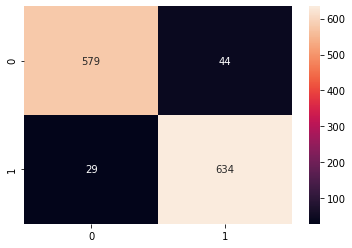

In [92]:
sns.heatmap(confusion_matrix(y_test,y_pred1),annot=True,fmt='g')

### Bernoulli Naive Bayes

In [93]:
bnb.fit(X_train,y_train)
y_pred1 = bnb.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test,y_pred1))
print("Confusion Matrix: ",'\n' ,confusion_matrix(y_test,y_pred1))
print("Precision score: ",precision_score(y_test,y_pred1))
print("Classification Report: ",'\n' ,classification_report(y_test,y_pred1))

Accuracy Score:  0.8934681181959565
Confusion Matrix:  
 [[534  89]
 [ 48 615]]
Precision score:  0.8735795454545454
Classification Report:  
               precision    recall  f1-score   support

           0       0.92      0.86      0.89       623
           1       0.87      0.93      0.90       663

    accuracy                           0.89      1286
   macro avg       0.90      0.89      0.89      1286
weighted avg       0.89      0.89      0.89      1286



<AxesSubplot:>

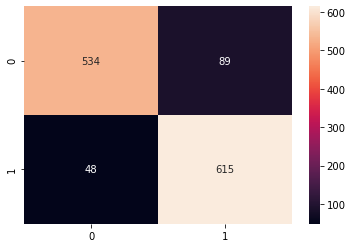

In [94]:
sns.heatmap(confusion_matrix(y_test,y_pred1),annot=True,fmt='g')

SO Tfidf with Multinomial Naive Bayes performs better than the other models

#### Implementing other models

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [96]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=40)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)


In [97]:
clfs = {
    'Support Vector Machine' : svc,
    'K- Nearest Neighbors' : knc, 
    'Multinomial Naive Bayes': mnb, 
    'Decision Tree': dtc, 
    'Logistic Regression': lrc, 
    'Random Forest': rfc, 
    'AdaBoost': abc, 
   
}

In [98]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    return accuracy,precision

In [99]:
train_classifier(svc,X_train,y_train,X_test,y_test)


(0.9455676516329704, 0.9431988041853513)

In [100]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  Support Vector Machine
Accuracy -  0.9455676516329704
Precision -  0.9431988041853513
For  K- Nearest Neighbors
Accuracy -  0.8639191290824261
Precision -  0.832425068119891
For  Multinomial Naive Bayes
Accuracy -  0.9432348367029549
Precision -  0.9351032448377581
For  Decision Tree
Accuracy -  0.8017107309486781
Precision -  0.8207547169811321
For  Logistic Regression
Accuracy -  0.9393468118195957
Precision -  0.9372197309417041
For  Random Forest
Accuracy -  0.9175738724727839
Precision -  0.9226100151745068
For  AdaBoost
Accuracy -  0.8880248833592534
Precision -  0.8961832061068702


In [101]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)


In [102]:
performance_df


,Algorithm,Accuracy,Precision
0,Support Vector Machine,0.945568,0.943199
4,Logistic Regression,0.939347,0.937220
2,Multinomial Naive Bayes,0.943235,0.935103
5,Random Forest,0.917574,0.922610
6,AdaBoost,0.888025,0.896183
1,K- Nearest Neighbors,0.863919,0.832425
3,Decision Tree,0.801711,0.820755


SVM performs better than the other models


# -----------------------------------------------------------------------------------------------------------------------------------------------------

In [113]:
from sklearn.svm import SVC

In [ ]:
# tfidf_vect1 = TfidfVectorizer(max_features=1000) ###change the maximun number of features
# data_features = tfidf_vect.fit_transform(df_new['Review'])
# data_features = data_features.toarray()
# data_features.shape

In [235]:
lrc_1 = LogisticRegression(solver='liblinear', penalty='l1')
lrc_1.fit(X_train,y_train)
y_pred = lrc_1.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)


In [236]:
print("Accuracy Score: ", accuracy)

Accuracy Score:  0.9393468118195957


#### Trying ensemble models

In [103]:
# Voting Classifier
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
lr = LogisticRegression(solver='liblinear', penalty='l1')
mnb = MultinomialNB()


from sklearn.ensemble import VotingClassifier

In [104]:
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('lr', lr)],voting='soft')


In [105]:
voting.fit(X_train,y_train)


VotingClassifier(estimators=[('svm',
                              SVC(gamma=1.0, kernel='sigmoid',
                                  probability=True)),
                             ('nb', MultinomialNB()),
                             ('lr',
                              LogisticRegression(penalty='l1',
                                                 solver='liblinear'))],
                 voting='soft')

In [106]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9494556765163297
Precision 0.9476047904191617


In [107]:

### STACKING
estimators=[('svm', svc), ('nb', mnb), ('lr', lr)]
final_estimator=RandomForestClassifier()

In [109]:
from sklearn.ensemble import StackingClassifier


In [110]:
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)


In [111]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9502332814930016
Precision 0.951734539969834


### pickling the model

In [237]:
import pickle
pickle.dump(tfidf_vect,open('tfidf.pkl','wb'))
pickle.dump(lrc_1,open('model.pkl','wb'))



### Streamlit

In [119]:
import streamlit as st

### Checking preprocessing for pickle data


In [178]:

from nltk.corpus import stopwords

In [179]:
# stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [190]:

### stripping html tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

### expanding the contractions
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

#remove the numericals present in the text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

def remove_non_ascii(text):
    new_words = []
    for word in text:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

### converting all the words to lower case
def to_lowercase(text):
    new_words = []
    for word in text:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

### removing the punctuations
def remove_punctuation(text):
    new_words = []
    for word in text:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# #### removing the stopwords
# def remove_stopwords(text):
#     new_words = []
#     for word in text:
#         if word not in stopwords:
#             new_words.append(word)
#     return new_words

# lemmatize the words
def lemmatize_list(text):
    new_words = []
    for word in text:
      new_words.append(lemmatizer.lemmatize(word))
    return new_words

def clean_text(text):
    text = strip_html_tags(text)
    text = replace_contractions(text)
    text = remove_numbers(text)
    text = remove_non_ascii(text)
    text = to_lowercase(text)
    text = remove_punctuation(text)
    # text = remove_stopwords(text)
    text = lemmatize_list(text)
    return ''.join(text)

In [191]:
clean_text("nice hotel expensive parking got good deal stay hotel anniversary, 2 22arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night")

'nice hotel expensive parking got good deal stay hotel anniversary  arrived late evening took advice previous reviews did valet parking check quick easy little disappointed nonexistent view room room clean nice size bed comfortable woke stiff neck high pillows not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe just noisy neighbors aveda bath products nice did not goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience having pay  parking night'

In [224]:
def transform_text1(text):
    text = text.lower()             ### converting all the words to lower case
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:                      ##### removing the stopwords and punctuations
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()

    for i in text:                      #### Removing the html tags
            soup = BeautifulSoup(str(i), "html.parser")
            y.append(soup.get_text())
    
    text = y[:]
    y.clear()

    for i in text:                      #### Replacing the contractions
        y.append(contractions.fix(i))
    text = y[:]
    y.clear()

    for i in text:                      #### Removing non-ascii characters
        new_word = unicodedata.normalize('NFKD', str(i)).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        y.append(new_word)
    text = y[:]
    y.clear()


    for i in text:                      #### Removing the numbers
        y.append(re.sub(r'\d+', '', i))
        
    text = y[:]
    y.clear()    
    
  

    for i in text:                      #### lemmatizing the words
        y.append(lemmatizer.lemmatize(i))
    
            
    return " ".join(y)

In [238]:
transform_text1("</n> Nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, 2 maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night")

'nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous review valet parking check quick easy little disappointed view room room clean nice size bed comfortable woke stiff neck high pillow soundproof like heard music room night morning loud bang door opening closing hear people talking hallway  maybe noisy neighbor aveda bath product nice goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience pay  parking night'